<div style="text-align:left;">

# <span style="text-decoration: underline;"><b>Projet de fin de formation - DATAGONG</b></span>

</div>


## <b>Analyse e‑commerce 2023 vs 2024 — thelook_ecommerce </b>

### Contexte & périmètre
Analyse de la performance e-commerce TheLook Europe sur le périmètre :
- Pays : France
- Département : Women
- Période : 01/01/2023 – 31/12/2024
Objectif : comparer 2023 vs 2024 via une EDA et le calcul de KPI métier.


Objectifs de l’EDA

Cette analyse exploratoire vise à :
- comprendre la structure des ventes et des retours sur 2023–2024,
- identifier les dynamiques temporelles, produits et géographiques,
- repérer d’éventuelles ruptures ou anomalies,
avant toute formalisation définitive des indicateurs de performance.


### 1. Descriptions des variables

#### 1.1. Aperçu global du jeu de données et re-typage des données
Commençons par importer notre jeu de données sous format csv et le convertir en DataFrame.

In [ ]:
import pandas as pd
import numpy as np
# Chargement du fichier csv
df = pd.read_csv("../data/thelook_fr_women_2023_2024.csv")

# Dimensions du jeu de données
print(f'Le jeu de donnée fait {df.shape[0]} lignes et {df.shape[1]} colonnes')

# En-tête du jeu de données
df.head()

Le jeu de donnée fait 1679 lignes et 20 colonnes


,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
0,19425,28112,6983,2023-01-01 06:18:03+00:00,Shipped,29.500000,16.048000,Shorts,Women,Fox,Fox Juniors Momentum Short,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,15644,F,France,Centre-Val de Loire,Corquilleroy
1,19425,28113,10597,2023-01-01 06:44:58+00:00,Shipped,20.000000,10.000000,Intimates,Women,Wacoal,Wacoal Women's B-Smooth Bralette,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,15644,F,France,Centre-Val de Loire,Corquilleroy
2,4710,6730,11792,2023-01-03 04:44:50+00:00,Complete,38.000000,18.468000,Intimates,Women,American Apparel,American Apparel Striped Chiffon Tank,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,3853,F,France,Île-de-France,Paris
3,16618,24006,329,2023-01-03 15:13:39+00:00,Complete,27.990000,16.402140,Tops & Tees,Women,Tri-Mountain,Tri-Mountain Women's 3/4-Sleeve Pique Knit Pol...,Complete,2023-01-03 18:58:00+00:00,2023-01-05 13:23:00+00:00,2023-01-09 10:25:00+00:00,13422,F,France,Hauts-de-France,Comines
4,4710,6731,5295,2023-01-05 06:43:09+00:00,Complete,56.880001,29.577601,Pants & Capris,Women,Lauren by Ralph Lauren,Lauren Ralph Lauren Velour Pants,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,3853,F,France,Île-de-France,Paris


Une fois notre DataFrame créé, intéressons-nous aux colonnes grace à la méthode .info de pandas, puis nous allons créer ensuite un dictionnaire les décrivant (définition, type, exemple).

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          1679 non-null   int64  
 1   order_item_id     1679 non-null   int64  
 2   product_id        1679 non-null   int64  
 3   item_created_at   1679 non-null   object 
 4   item_status       1679 non-null   object 
 5   sale_price        1679 non-null   float64
 6   cost              1679 non-null   float64
 7   category          1679 non-null   object 
 8   department        1679 non-null   object 
 9   brand             1677 non-null   object 
 10  product_name      1679 non-null   object 
 11  order_status      1679 non-null   object 
 12  order_created_at  1679 non-null   object 
 13  shipped_at        1133 non-null   object 
 14  delivered_at      636 non-null    object 
 15  user_id           1679 non-null   int64  
 16  gender            1679 non-null   object 


On observe déjà que l'essentiel des valeurs manquantes se trouve dans les deux variables `shipped_at` et `delivered_at`, ce qui n'est pas surprenant si on considère qu'un certain nombre de commandes n'ont pas encore été expédiées et livrées au moment de l'extraction des bases.
Il existe également 2 valeurs manquantes pour la colonne brand.

On peut d'ores et déjà changer le type object en date pour les colonnes de date et en category pour les colonnes catégorielles . 

In [3]:
# Affichage des colonnes catégorielles
df.select_dtypes(include='object').head()

,item_created_at,item_status,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,gender,country,state,city
0,2023-01-01 06:18:03+00:00,Shipped,Shorts,Women,Fox,Fox Juniors Momentum Short,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,F,France,Centre-Val de Loire,Corquilleroy
1,2023-01-01 06:44:58+00:00,Shipped,Intimates,Women,Wacoal,Wacoal Women's B-Smooth Bralette,Shipped,2022-12-29 10:00:00+00:00,2022-12-30 11:29:00+00:00,NaN,F,France,Centre-Val de Loire,Corquilleroy
2,2023-01-03 04:44:50+00:00,Complete,Intimates,Women,American Apparel,American Apparel Striped Chiffon Tank,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,F,France,Île-de-France,Paris
3,2023-01-03 15:13:39+00:00,Complete,Tops & Tees,Women,Tri-Mountain,Tri-Mountain Women's 3/4-Sleeve Pique Knit Pol...,Complete,2023-01-03 18:58:00+00:00,2023-01-05 13:23:00+00:00,2023-01-09 10:25:00+00:00,F,France,Hauts-de-France,Comines
4,2023-01-05 06:43:09+00:00,Complete,Pants & Capris,Women,Lauren by Ralph Lauren,Lauren Ralph Lauren Velour Pants,Complete,2023-01-03 08:12:00+00:00,2023-01-03 09:14:00+00:00,2023-01-04 03:03:00+00:00,F,France,Île-de-France,Paris


Les date sont au format objet, ce qui n'est pas très pratique pour trier notre DataFrame.
Nous allons commencer par parser les dates.

In [4]:
# Colonnes de date 
col_dates = [
    "item_created_at", 
    "order_created_at", 
    "shipped_at", 
    "delivered_at"
]

# Formatage de la date 
for c in col_dates:
    dates = pd.to_datetime(df[c], errors='coerce')
    df[c] = dates

Maintenant que les dates sont parsées, nous allons déterminer pour quelles colonnes il faudrait typer en category.

En effet, il n'est pas souhaitable de typer en category lorsqu'il y a un nombre trop important de modalités pour une colonne donnée. Cherchons alors à connaître le nombre de modalités uniques pour chaque colonne avec la méthode nunique.

In [5]:
# Nombre de modalités pour les colonnes object
for col in df.select_dtypes(include='object').columns.to_list():
    print(f'Colonne {col} : {df[col].nunique()}')

Colonne item_status : 5
Colonne category : 22
Colonne department : 1
Colonne brand : 657
Colonne product_name : 1559
Colonne order_status : 5
Colonne gender : 1
Colonne country : 1
Colonne state : 13
Colonne city : 547


 Les colonnes `brand` et `product_name` ont un nombre important de modalités uniques. Ainsi, nous les laisserons en format object.

 Changeons le type des autres colonnes catégorielles :

In [6]:
# Colonnes catégorielles
cat_list = [
    "item_status", 
    "category", 
    "department", 
    "order_status", 
    "gender", 
    "country", 
    "state", 
    "city"
]

# Changement des type object en category pour les variables catégorielles
df[cat_list] = df[cat_list].astype('category')

Finalement après toutes ces opérations, il est temps de re-contrôler le type de nos données.

In [7]:
# Contrôle du type des données
df.dtypes

order_id                          int64
order_item_id                     int64
product_id                        int64
item_created_at     datetime64[ns, UTC]
item_status                    category
sale_price                      float64
cost                            float64
category                       category
department                     category
brand                            object
product_name                     object
order_status                   category
order_created_at    datetime64[ns, UTC]
shipped_at          datetime64[ns, UTC]
delivered_at        datetime64[ns, UTC]
user_id                           int64
gender                         category
country                        category
state                          category
city                           category
dtype: object

Nos données catégorielles et de dates sont à présent bien typées. On créé maintenant notre dictionnaire de données permettant de décrire les colonnes.

#### 1.2. Création du mini-dictionnaire de données
On va maintenant procéder à la création du du mini-dictionnaire des données.

**Grain du dataset**  
Chaque ligne du fichier correspond à **un article (ligne de commande)** associé :
- à une **commande** (`order_id`),
- à un **client** (`user_id`),
- à un **produit** (`product_id`).

Le fichier CSV est **fourni par l’équipe pédagogique** et correspond au sous-périmètre :
France × Women × 2023–2024.  
Il constitue la base unique de l’analyse exploratoire (EDA) en Python.

---

| Colonne | Type | Définition métier | Remarques |
|------|------|--------------------|-----------|
| `order_id` | int64 | Identifiant unique de la commande. | Une commande peut contenir plusieurs articles. |
| `order_item_id` | int64 | Identifiant unique de la ligne de commande (article). | Doit être unique. Sert à vérifier l’absence de doublons métier. |
| `product_id` | int64 | Identifiant unique du produit acheté. | – |
| `item_created_at` | datetime (UTC) | Date de création de la ligne de commande. | Date de référence pour le périmètre temporel. |
| `item_status` | category | Statut de la ligne de commande (ex. `Complete`, `Returned`). | – |
| `sale_price` | float64 | Prix de vente de l’article. | – |
| `cost` | float64 | Coût d’achat ou de fabrication du produit. | – |
| `category` | category | Catégorie du produit. | – |
| `department` | category | Département du produit (Women). | Variable constante dans le périmètre. |
| `brand` | object | Marque du produit. | – |
| `product_name` | object | Nom du produit. | – |
| `order_status` | category | Statut de la commande (ex. `Complete`, `Shipped`). | Statut global, distinct du statut des lignes. |
| `order_created_at` | datetime (UTC) | Date de création de la commande. | Utilisée pour les analyses au niveau commande. |
| `shipped_at` | datetime (UTC) | Date d’expédition de l’article. | Valeurs manquantes attendues. |
| `delivered_at` | datetime (UTC) | Date de livraison de l’article. | Valeurs manquantes attendues. |
| `user_id` | int64 | Identifiant unique du client. | Un client peut passer plusieurs commandes. |
| `gender` | category | Genre déclaré du client. | – |
| `country` | category | Pays de résidence du client. | Variable constante dans le périmètre. |
| `state` | category | Région / État du client. | – |
| `city` | category | Ville du client. | – |

---

**Notes méthodologiques**
- Le dataset est au **grain ligne de commande** (article), et non au niveau commande.
- Les colonnes logistiques (`shipped_at`, `delivered_at`) peuvent légitimement contenir des valeurs manquantes.


### 2. Contrôle de qualité des données

#### 2.1. Traitement des doublons
On va chercher dans un premier temps à voir s'il existe des observations intégralement dupliquées.

In [8]:
# Recherche d'observations intégralement dupliquées 
print(f"Il y a {df.duplicated().sum()} ligne(s) intégralement dupliquée(s)")

Il y a 0 ligne(s) intégralement dupliquée(s)


`order_item_id` étant la clé Métier, il est primordial de vérifier son unicité :

In [9]:
df['order_item_id'].is_unique
df['order_item_id'].duplicated().sum()

np.int64(0)

Nous constatons qu'il n'y a aucune ligne intégralement dupliquée et qu'aucun doublon n’est détecté sur order_item_id, ce qui confirme l’unicité des lignes de vente et la fiabilité des agrégations futures.

#### 2.2. Traitement des valeurs manquantes
On va maintenant chercher à savoir s'il existe des valeurs manquantes et comment les traiter. On a vu que pour certains champs comme `shipped_at` et `delivered_at` il était normal d'avoir des valeurs manquantes. Celles-ci n’affectent pas les analyses de performance (CA, marge, retours) car elles ne sont pas utilisées dans les calculs ultérieurs. 
Il sera préférable de les laisser simplement en NaT. 


On en observe en revanche deux dans le champ `brand`. Cherchons alors la meilleure méthode d'imputation pour ces deux observations. 

In [11]:
# Affichage des observations où on a pas d'information concernant la variable brand
df[df["brand"].isna()]

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,NaN,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,NaN,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Une première stratégie d'imputation serait de chercher si ces produits se retrouvent ailleurs dans le DataFrame et leur imputer la valeur de brand d'un hypothétique même produit.

In [12]:
# Identification des product_id dont la marque est manquante
missing_brand_products = df.loc[df["brand"].isna(), "product_id"].unique()

# Vérification de s'ils apparaissent ailleurs dans le dataset
df[df["product_id"].isin(missing_brand_products)]

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,NaN,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,NaN,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Ces produits sont uniques, on ne peut donc pas imputer avec la valeur de brand hypothétique. On va donc se contenter de remplacer par *"missing"*.

In [13]:
# Imputation par missing
df.fillna({"brand": "missing"}, inplace=True)

# Affichage des observations où on a pas d'information concernant la variable brand
df[df["brand"]=="missing"]

,order_id,order_item_id,product_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,shipped_at,delivered_at,user_id,gender,country,state,city
320,40643,58980,755,2023-06-24 08:17:59+00:00,Returned,28.950001,15.14085,Tops & Tees,Women,missing,The Very Hungry Caterpillar Classic Book Women...,Returned,2023-06-24 08:55:00+00:00,2023-06-24 20:32:00+00:00,2023-06-28 18:54:00+00:00,32624,F,France,Île-de-France,Paris
1237,25047,36362,13863,2024-08-12 09:56:12+00:00,Complete,24.250000,9.55450,Accessories,Women,missing,Husky Animal Hat with Mittens,Complete,2024-08-12 13:30:00+00:00,2024-08-15 12:12:00+00:00,2024-08-18 05:02:00+00:00,20152,F,France,Île-de-France,Vélizy-Villacoublay


Les valeurs manquantes concernent principalement les dates de livraison et d’expédition, ce qui est cohérent avec des commandes non encore livrées ou annulées.
La variable `brand` comporte 2 valeurs manquantes sur 1 679 lignes
(soit 0,12 % du jeu de données). Ces valeurs ont été imputées
sous la modalité `"missing"` faute de plus d'informations. Cette proportion est jugée négligeable
et n’impacte pas les analyses exploratoires.


#### 2.3. Cohérence des bornes temporelles


L’analyse est réalisée au **grain ligne de commande (article)**.  
Il existe donc deux dates distinctes dans le dataset :
- la date de création de la commande (`order_created_at`),
- la date de création de la ligne de commande (`item_created_at`).

Dans un contexte e-commerce réel, ces deux dates peuvent différer.  
Par exemple, une commande peut être créée juste avant minuit, tandis que les lignes qui la composent sont enregistrées quelques secondes ou minutes plus tard, parfois après un changement de date (notamment en raison des fuseaux horaires ou de traitements techniques asynchrones).

Afin de respecter le **grain d’analyse** et le **périmètre temporel demandé**, le filtrage est donc effectué sur la date de création des lignes (`item_created_at`) et non sur la date de création des commandes.  
Ce choix permet d’éviter l’exclusion ou l’inclusion incorrecte de lignes situées à la frontière entre deux périodes.


In [14]:
# Définition des bornes temporelles
date_limits = {
    "avant 2023": "2023-01-01 00:00:00+00:00",
    "après 2024": "2025-01-01 00:00:00+00:00"
}

# Affichage des bornes min / max
print(
    f"La date la plus ancienne de item_created_at est : {df['item_created_at'].min()}\n"
    f"La date la plus récente de item_created_at est : {df['item_created_at'].max()}\n"
)

# Comptage des dates hors périmètre
for label, limit in date_limits.items():
    count = (
        (df["item_created_at"] < limit).sum()
        if "avant" in label
        else (df["item_created_at"] > limit).sum()
    )
    print(f"Colonne item_created_at : {count} dates {label}")

La date la plus ancienne de item_created_at est : 2023-01-01 06:18:03+00:00
La date la plus récente de item_created_at est : 2024-12-31 10:40:48+00:00

Colonne item_created_at : 0 dates avant 2023
Colonne item_created_at : 0 dates après 2024


Toutes les dates sont comprises entre 2023 et 2024, 
le périmètre temporel est respecté.


Pour terminer, nous contrôlons la cohérence chronologique des différentes
étapes du cycle de vie des commandes (création, expédition et livraison).
L’objectif est de détecter d’éventuelles incohérences temporelles et
d’évaluer leur impact sur les analyses exploratoires.


In [ ]:
# Controle de la cohérence chronologique order_created_at < shipped_at
df[
    (df["shipped_at"].notna()) &
    (df["shipped_at"] < df["order_created_at"])
].shape[0]

0

In [ ]:
# Controle de la cohérence chronologique shipped_at < delivered_at
mask_delivered = (
    df["delivered_at"].notna()
    & df["shipped_at"].notna()
    & (df["delivered_at"] < df["shipped_at"])
)

mask_delivered.sum()

np.int64(0)

Les contrôles de cohérence temporelle effectués sur les dates
d’expédition et de livraison ne révèlent aucune incohérence
chronologique sur les lignes concernées.

**Conclusion des contrôles de qualité**

Les contrôles effectués n’ont pas mis en évidence d’anomalies bloquantes.
Les valeurs manquantes observées concernent essentiellement des variables logistiques non utilisées dans les calculs de performance.
Les identifiants de lignes (`order_item_id`) sont uniques, garantissant la fiabilité des agrégations.
Les données sont jugées exploitables pour les analyses exploratoires et le calcul des KPI.


### 3. Explorations descriptives

#### 3.1. Distribution des données de prix de vente et de coût
Dans cette phase exploratoire, les analyses sont réalisées sur l’ensemble des lignes de commande, tous statuts confondus afin de comprendre la structure des données. Les filtres métier stricts (statut "Complete") sont appliqués ultérieurement lors du calcul des KPI.

Commençons tout d'abord par faire un contrôle qualité Métier rapide sur les prix de vente et les coûts. Ceux-ci ne doivent en aucun cas être négatifs, de plus le prix de vente doit toujours être supérieur au coût qui lui est associé.

In [ ]:
# Contrôle Métier sur les colonnes prix de vente et coût
df[
    (df["sale_price"] <= 0) |
    (df["cost"] < 0) |
    (df["sale_price"] < df["cost"])
].shape[0]

0

Aucune valeur aberrante n’est observée sur les variables de prix et de coût.
Les prix de vente sont strictement positifs et supérieurs aux coûts associés,
ce qui sécurise les analyses ultérieures de performance.


Poursuivons avec la distribution des données liées aux prix de vente et au coût des produits. Utilisons pour cela la méthode describe().

In [15]:
# Méthode describe sur les colonnes prix de vente et coût
df[["sale_price", "cost"]].describe()

,sale_price,cost
count,1679.000000,1679.000000
mean,57.021769,27.460066
std,69.682245,31.854450
min,1.820000,0.749840
25%,19.990000,9.681000
50%,38.000000,18.230800
75%,68.000000,33.232345
max,903.000000,437.052001


Les statistiques descriptives montrent des ordres de grandeur cohérents avec une activité e-commerce de prêt-à-porter.
La distribution des prix et des coûts est asymétrique à droite, avec une médiane inférieure à la moyenne, traduisant la présence de quelques articles à prix plus élevés.
Les valeurs minimales sont strictement positives, ce qui ne suggère pas d’erreurs de saisie.
Les valeurs maximales élevées restent plausibles et ne justifient pas de traitement particulier à ce stade.
Les données sont jugées exploitables pour la suite de l’analyse.


Nous pouvons également représenter nos données avec un histogramme et ainsi avoir une meilleure idée de la structure des prix de vente/coûts.

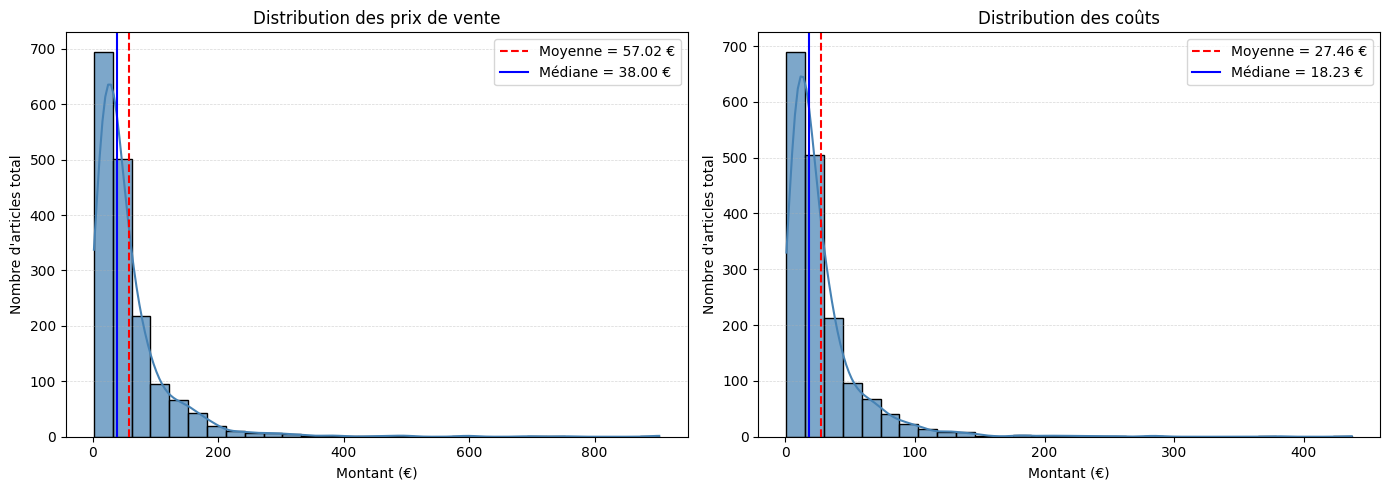

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Titres
titles = {
    "sale_price": "Distribution des prix de vente",
    "cost": "Distribution des coûts"
}

# Colonnes
colonnes = ["sale_price", "cost"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col in zip(axes, colonnes):
    x = df[col]

    # Statistiques
    mean = x.mean()
    median = x.median()

    # Histogramme
    sns.histplot(
        x,
        bins=30,
        edgecolor="black",
        alpha=0.7,
        kde=True,
        color="steelblue",
        ax=ax
    )

    # Lignes moyenne et médiane
    ax.axvline(mean, linestyle="--", color="red", label=f"Moyenne = {mean:.2f} €")
    ax.axvline(median, linestyle="-", color="blue", label=f"Médiane = {median:.2f} €")

    # Grille
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    # Titres et labels
    ax.set_title(titles[col])
    ax.set_xlabel("Montant (€)")
    ax.set_ylabel("Nombre d'articles total")
    ax.legend()

plt.tight_layout()
plt.show()


Les distributions des prix de vente et des coûts présentent une forte asymétrie à droite.  
La majorité des articles se situe sur des niveaux de prix relativement faibles, tandis qu’un nombre limité d’articles affiche des valeurs très élevées, générant une longue traîne. Cette asymétrie se reflète dans l’écart marqué entre la moyenne et la médiane, la moyenne étant tirée vers le haut par les valeurs extrêmes.

**Interprétation métier**

Ces distributions suggèrent un catalogue composé majoritairement de produits à prix accessibles, complété par une offre plus restreinte de produits premium. Les articles à prix élevé, bien que peu nombreux, peuvent jouer un rôle disproportionné dans le chiffre d’affaires et la marge. Cette structure justifie l’analyse complémentaire via des boxplots, des échelles logarithmiques et des analyses de contribution afin de mieux appréhender l’impact réel de ces valeurs extrêmes sur la performance globale.


**Répartition des statuts de lignes de commande**

Afin de compléter cette première exploration globale, il est utile d’examiner la répartition des lignes selon leur statut, afin de mieux comprendre la structure opérationnelle du dataset.

In [135]:
# Nombre de lignes par statut
df["item_status"].value_counts()

item_status
Shipped       497
Complete      425
Processing    306
Cancelled     240
Returned      211
Name: count, dtype: int64

Le tableau ci-dessus présente la distribution des lignes de commande selon leur statut (item_status) sur l’ensemble du dataset.

**Conventions d’analyse pour les ventes réalisées**

À partir de cette section, les analyses se concentrent exclusivement sur les lignes correspondant à des ventes effectivement réalisées. Une ligne de commande est considérée comme une vente réalisée uniquement lorsque son statut est Complete. Les statuts Processing, Shipped et Cancelled correspondent à des étapes intermédiaires ou annulées du cycle de commande et ne garantissent pas la réalisation effective du revenu ; ils sont donc exclus des analyses présentées dans la suite de cette section.

#### 3.2. Contribution par marque, catégorie, ville, saisonnalité mensuelle 
Maintenant nous allons nous intéresser à la contribution au CA net sur 2023-2024 des marques, catégories, zones géographiques et selon le mois de l'année. Dans ce projet, le chiffre d’affaires net est défini comme la somme des sale_price des lignes au statut Complete (convention du projet).
Les graphiques suivants présentent la contribution des principales marques,
catégories et villes au chiffre d’affaires total du périmètre.


##### 3.2.1. Contribution par marque

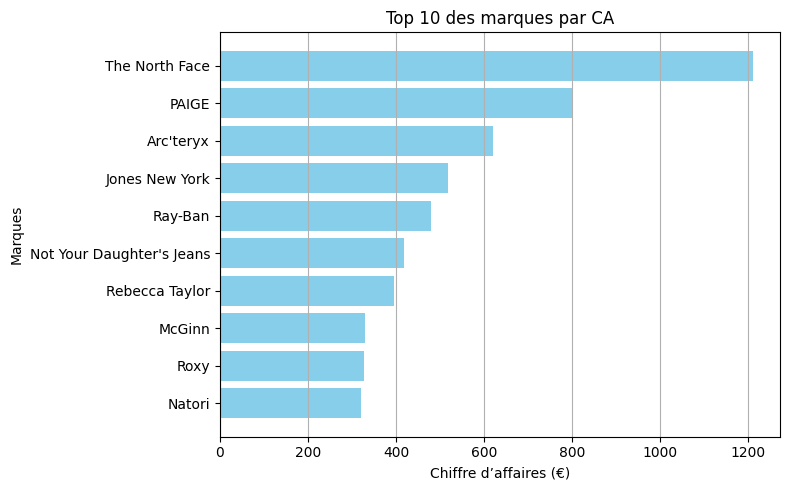

In [ ]:
# Filtre sur les articles au statut "Complete"
df_net = df[df["item_status"] == "Complete"].copy()

# Contribution par marque
ca_marque = df_net.groupby('brand')['sale_price'].sum().sort_values(ascending=False)

# Sélection du top 10 marques par CA
top10_marques = ca_marque.head(10)

# Construction figure
fig, ax = plt.subplots(figsize=(8, 5))

# Barres horizontales
ax.barh(top10_marques.index, top10_marques.values, color="skyblue")
ax.invert_yaxis()

# Mise en forme 
ax.set_title("Top 10 des marques par CA")
ax.set_xlabel("Chiffre d’affaires (€)")
ax.set_ylabel("Marques")
ax.grid(visible=True, which='major', axis='x')

plt.tight_layout()
plt.show()

Le chiffre d’affaires est fortement concentré sur un nombre limité de marques.  
La marque *The North Face* se distingue nettement comme le principal contributeur, suivie par *PAIGE* et *Arc'teryx. L’écart entre les premières marques et le bas du top 10 reste significatif, ce qui met en évidence une distribution inégale du chiffre d’affaires par marque.

**Interprétation métier**

Cette concentration suggère une dépendance partielle à quelques marques majeures dans le périmètre étudié. Ces marques constituent des leviers clés de performance, mais également un point de vigilance en cas de baisse de demande, de rupture d’approvisionnement ou de changement de politique commerciale.


##### 3.2.2. Contribution par catégorie

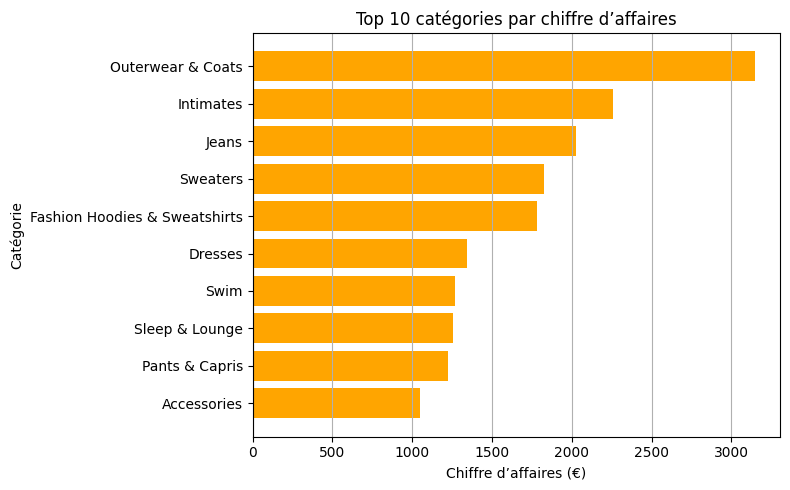

In [103]:
# Contribution par catégorie
ca_categorie = df_net.groupby('category', observed=False)['sale_price'].sum().sort_values(ascending=False)

# Top 10 catégories par CA
top10_categories = ca_categorie.sort_values(ascending=False).head(10)

# Figure
fig, ax = plt.subplots(figsize=(8, 5))

# Barres horizontales
ax.barh(top10_categories.index, top10_categories.values, color="orange")
ax.invert_yaxis()

# Mise en forme identique
ax.set_title("Top 10 catégories par chiffre d’affaires")
ax.set_xlabel("Chiffre d’affaires (€)")
ax.set_ylabel("Catégorie")
ax.grid(visible=True, which='major', axis='x')

plt.tight_layout()
plt.show()



Le chiffre d’affaires est majoritairement généré par quelques catégories clés.  
La catégorie *Outerwear & Coats* apparaît comme le principal contributeur, suivie par *Intimates* et *Jeans*. L’écart progressif observé entre les catégories souligne une hiérarchisation claire des familles de produits en termes de performance commerciale.

**Interprétation métier**

Ces résultats indiquent que la performance globale repose en grande partie sur des catégories « cœur de gamme », à forte demande et à rotation élevée. Ces catégories constituent des axes prioritaires pour les décisions d’assortiment, de gestion des stocks et de pilotage des marges, tout en justifiant une vigilance accrue sur les catégories moins contributrices.


##### 3.2.3. Contribution par ville

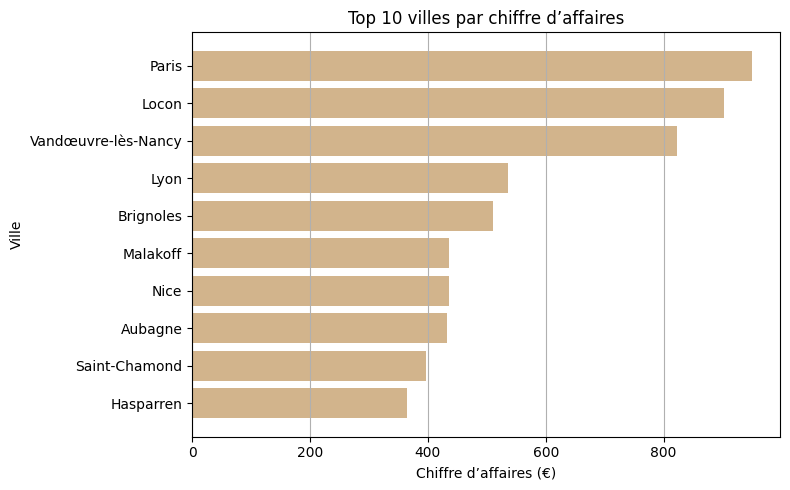

In [104]:
# Contribution par ville
ca_ville = df_net.groupby('city', observed=False)['sale_price'].sum().sort_values(ascending=False)

# Top 10 villes par CA
top10_villes = ca_ville.sort_values(ascending=False).head(10)

# Figure unique
fig, ax = plt.subplots(figsize=(8, 5))

# Barres horizontales (JAUNE)
ax.barh(top10_villes.index, top10_villes.values, color="tan")
ax.invert_yaxis()

# Mise en forme identique
ax.set_title("Top 10 villes par chiffre d’affaires")
ax.set_xlabel("Chiffre d’affaires (€)")
ax.set_ylabel("Ville")
ax.grid(visible=True, which='major', axis='x')

plt.tight_layout()
plt.show()


Le chiffre d’affaires est fortement concentré géographiquement.  
La ville de *Paris* se distingue comme principal contributeur, avec un niveau de chiffre d’affaires supérieur aux autres villes du top 10. *Locon* et *Vandoeuvre-lè-nancy* suivent à distance, tandis que le reste des villes affiche des niveaux de contribution relativement homogènes.

**Interprétation métier**

Cette concentration géographique met en évidence le poids des grandes agglomérations dans la performance e-commerce mais aussi de ville plus petites. Elle suggère des opportunités de ciblage marketing et d’optimisation de l’expérience client dans les zones urbaines majeures, tout en invitant à explorer le potentiel de croissance dans des villes de taille intermédiaire.


##### 3.2.4. Contribution par saisonnalité mensuelle

Nous allons maintenant créer une colonne month pour analyser la saisonnalité mensuelle. La saisonnalité mensuelle est analysée en agrégeant les ventes des années 2023 et 2024 afin de faire ressortir le profil saisonnier global du périmètre étudié.

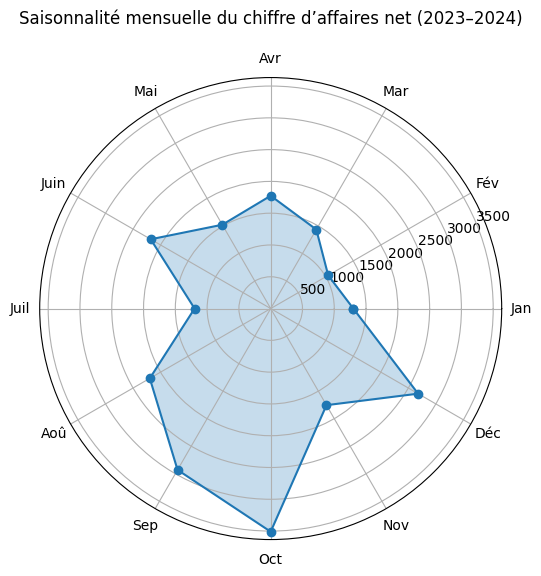

In [ ]:
# Création colonne month
df_net["month"] = df_net["item_created_at"].dt.month


# Agrégation mensuelle sur 2023–2024
seasonality = (
    df_net
    .groupby("month")["sale_price"]
    .sum()
    .reindex(range(1, 13), fill_value=0)
)

# Angles pour les mois
angles = np.linspace(0, 2 * np.pi, 12, endpoint=False)
angles = np.concatenate([angles, [angles[0]]])
values = np.concatenate([seasonality.values, [seasonality.values[0]]])

# Courbe polaire
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.plot(angles, values, marker="o")
ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(
    ["Jan", "Fév", "Mar", "Avr", "Mai", "Juin",
     "Juil", "Aoû", "Sep", "Oct", "Nov", "Déc"]
)

ax.set_title("Saisonnalité mensuelle du chiffre d’affaires net (2023–2024)", pad=20)

plt.show()


L’analyse de la contribution mensuelle met en évidence une saisonnalité marquée du chiffre d’affaires net.  
Les mois d’avril, juin, août, septembre, octobre et décembre apparaissent comme les plus contributifs, avec un pic notable en fin d’année. À l’inverse, certains mois comme février ou juillet présentent des niveaux de chiffre d’affaires plus faibles.

**Interprétation métier**

Cette saisonnalité est cohérente avec des comportements d’achat liés aux cycles de consommation dans le prêt-à-porter (renouvellement de garde-robe, périodes promotionnelles, achats de fin d’année). Cette analyse est réalisée sur les ventes finalisées (Complete) et reflète donc le chiffre d’affaires net


### 4. Comparaison 2023 vs 2024

A présent, voyons l'évolution mensuelle des ventes sur les années 2023 et 2024. Comme avant, les analyses portent exclusivement sur les lignes de vente finalisées (statut Complete), afin de décrire la performance e-commerce réellement réalisée sur le périmètre.

Toutes les analyses temporelles comparatives 2023 vs 2024 seront basées sur item_created_at (date des lignes) afin de respecter le périmètre ainsi que les nouvelles colonnes de dates month et year.

In [126]:
# Création des colonnes year et month de création des lignes de commande
df_net["year"] = df_net["item_created_at"].dt.year
df_net["month"] = df_net["item_created_at"].dt.month

In [127]:
# Evaluation du CA par année
df_net.groupby("year")["sale_price"].sum()

year
2023     7806.319998
2024    15716.280016
Name: sale_price, dtype: float64

Tout d'abord on remarque rapidement que ce chiffre d'affaires net a significativement augmenté en 2024 par rapport à 2023. Regardons à présent le détail mois par mois.

In [128]:
# Création du dataframe regroupant les ventes par mois et années
monthly_ca = (
    df_net.groupby(["year", "month"])["sale_price"]
    .sum()
    .reset_index()
)

# Basculement du dataframe regroupant les ventes par mois et années
monthly_ca_pivot = monthly_ca.pivot(
    index="month",
    columns="year",
    values="sale_price"
)
monthly_ca_pivot

year,2023,2024
month,,
1,379.060003,920.759998
2,273.110003,771.389997
3,282.139999,1153.249990
4,743.299998,1031.020017
5,641.709999,880.730000
6,447.300000,1732.519998
7,384.859993,812.279997
8,863.260000,1332.590012
9,1169.070000,1761.389992


Nous avons une table représentant l'évolution mensuelle des ventes. Nous pouvons rajouter le différentiel mois à mois entre les deux années.

In [129]:
# Ajout de la variation absolue de chiffre d'affaires mois à mois
monthly_ca_pivot["delta_abs"] = (
    monthly_ca_pivot[2024]
    - monthly_ca_pivot[2023]
)

# Ajout de la variation relative de chiffre d'affaires mois à mois
monthly_ca_pivot["delta_pct"] = (
    (monthly_ca_pivot[2024] - monthly_ca_pivot[2023])
    / monthly_ca_pivot[2023]
)

monthly_ca_pivot

year,2023,2024,delta_abs,delta_pct
month,,,,
1,379.060003,920.759998,541.699995,1.429061
2,273.110003,771.389997,498.279994,1.824466
3,282.139999,1153.249990,871.109990,3.087510
4,743.299998,1031.020017,287.720018,0.387085
5,641.709999,880.730000,239.020001,0.372474
6,447.300000,1732.519998,1285.219998,2.873284
7,384.859993,812.279997,427.420004,1.110586
8,863.260000,1332.590012,469.330011,0.543672
9,1169.070000,1761.389992,592.319992,0.506659


Il serait maintenant intéressant d'afficher le tout sur un graphe de manière à mieux visualiser les pics ou creux.

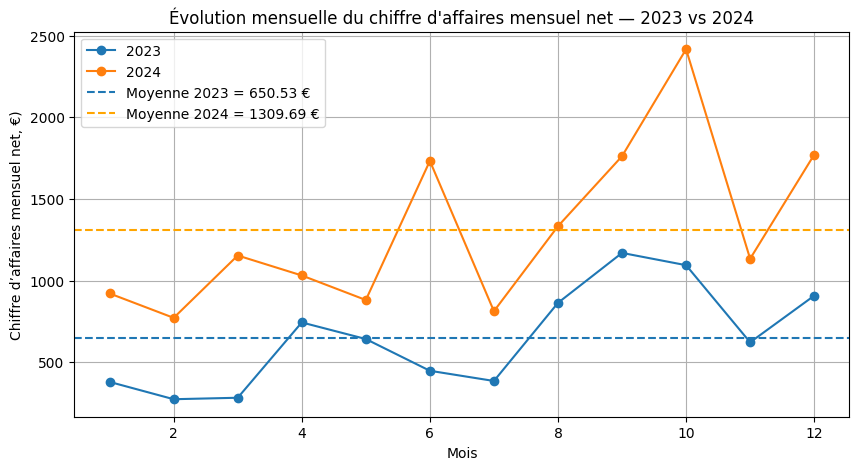

In [130]:
# Création du graphique des CA mensuels 2023 vs 2024
ax = monthly_ca_pivot[[2023, 2024]].plot(
    kind="line",
    marker="o",
    figsize=(10, 5)
)

# Calcul des moyennes annuelles
mean_2023 = monthly_ca_pivot[2023].mean()
mean_2024 = monthly_ca_pivot[2024].mean()

# Ajout des lignes horizontales correspondant aux moyennes
ax.axhline(mean_2023, linestyle="--", label=f"Moyenne 2023 = {mean_2023:.2f} €")
ax.axhline(mean_2024, linestyle="--", color='orange', label=f"Moyenne 2024 = {mean_2024:.2f} €")

# Paramétrage du graphique
ax.set_title("Évolution mensuelle du chiffre d'affaires mensuel net — 2023 vs 2024")
ax.set_xlabel("Mois")
ax.set_ylabel("Chiffre d’affaires mensuel net, €)")

# Affichage de la légende et de la grille
ax.legend()
ax.grid(True)

# Affichage plot
plt.show()

La comparaison mensuelle met en évidence une dynamique globalement plus favorable en 2024.  
Sur la majorité des mois, le chiffre d’affaires net de 2024 dépasse celui de 2023, avec des écarts particulièrement marqués au printemps et à l’automne. Les moyennes mensuelles confirment cette tendance, avec un niveau moyen plus élevé en 2024 qu’en 2023.

**Interprétation métier**

Cette évolution suggère une croissance de l’activité en 2024, portée à la fois par des pics plus élevés et une performance plus régulière sur l’année. Les mois d’octobre et de fin d’année apparaissent comme des périodes clés de création de valeur.


Synthèse de l’EDA

Cette analyse exploratoire met en évidence :
- des différences marquées entre 2023 et 2024,
- une concentration des ventes sur certains segments produits,
- des dynamiques temporelles et géographiques fortes.

Ces constats guideront la définition des KPI
et la construction du tableau de bord.


### 5. KPI Python

Pour finir notre EDA Python, calculons et affichons quelques indicateurs clés de la performance globale.
Comme avant nous parlerons de CA net, c'est à dire que les lignes de commande au statut autre que "Complete" seront exclues du calcul.

**Chiffre d’affaires net** : somme des sale_price des lignes au statut "Complete".

In [ ]:
# Création des colonnes year et month
df["year"] = df["item_created_at"].dt.year
df["month"] = df["item_created_at"].dt.month

# Calcul du chiffre d'affaires
ventes = df[df["item_status"] == "Complete"]
ca_total = ventes.groupby("year")["sale_price"].sum()

# Affichage du chiffre d'affaires
print("=== Chiffre d'affaires par année ===")

for annee, ca in ca_total.items():
    print(f" {annee} : {ca:.2f} €")

=== Chiffre d'affaires par année ===
 2023 : 7806.32 €
 2024 : 15716.28 €


**Marge brute** : somme des sale_price – cost des lignes au statut "Complete".

In [113]:
# Calcul de la marge brute
cost_total = ventes.groupby("year")["cost"].sum()
marge_brute = ca_total - cost_total

# Affichage de la marge brute
print("=== Marge brute par année ===")

for annee, mb in marge_brute.items():
    print(f"{annee} : {mb:.2f} €")

=== Marge brute par année ===
2023 : 4075.34 €
2024 : 8134.61 €


Nous pouvons calculer le taux de marge brute. Taux de Marge brute = Marge brute/CA net.

In [114]:
# Calcul du taux de marge brute
taux_marge_brute = (ca_total-cost_total) / (ca_total)

# Affichage du taux de marge brute
print("=== Taux de marge brute par année ===")

for annee, tmb in taux_marge_brute.items():
    print(f"{annee} : {tmb*100:.2f}%")

=== Taux de marge brute par année ===
2023 : 52.21%
2024 : 51.76%


**Panier moyen** : Le panier moyen est calculé comme :
CA net / nombre de commandes ayant généré du revenu (> 0).
Le calcul est réalisé à l’échelle de la commande (order_id),
car c’est l’unité de décision du client.


In [115]:
# Calcul du panier moyen par commande
panier_moyen = (
    ventes.groupby(["year", "order_id"])["sale_price"]
    .sum()
    .groupby("year")
    .mean()
)

# Affichage du panier moyen par commande
print("=== Panier moyen par année ===")

for annee, pm in panier_moyen.items():
    print(f"{annee} : {pm:.2f} €")

=== Panier moyen par année ===
2023 : 80.48 €
2024 : 85.41 €


**Taux de retour** : part des lignes au statut "Returned" parmi les lignes vendues : ventes + retours :
Ici, on va considérer les articles retournés comme ayant le statut "Returned".

In [116]:
# Lignes vendues + retournées
ventes_retour = df[df["item_status"].isin(["Returned", "Complete"])]

taux_retour_par_an = (
    ventes_retour.assign(is_return=ventes_retour["item_status"] == "Returned")
    .groupby("year")["is_return"]
    .mean()
)

# Affichage du taux de retour
print("=== Taux de retour par année ===")

for annee, tr in taux_retour_par_an.items():
    print(f"{annee} : {tr*100:.2f} %")

=== Taux de retour par année ===
2023 : 37.87 %
2024 : 30.42 %


Le taux de retour observé est relativement élevé, ce qui constitue un point de vigilance et justifie une analyse plus fine par catégorie dans la suite du projet.

**Taux de ré‑achat** : part des clients ayant ≥ 2 commandes complètes sur une année : Une commande est comptabilisée dans une année dès lors qu’elle contient au moins une ligne vendue sur cette année.

In [117]:
# Lignes de vente (Complete) sur le périmètre
sales = df[df["item_status"] == "Complete"].copy()

# Année basée sur la date de création des lignes
sales["year"] = sales["item_created_at"].dt.year

# Nombre de commandes valides par client et par année
nb_orders_per_user_year = (
    sales.groupby(["year", "user_id"])["order_id"]
         .nunique()
)

# Taux de ré-achat par année
for year in [2023, 2024]:
    nb_orders = nb_orders_per_user_year.loc[year]  # série indexée par user_id
    taux_reachat = (nb_orders >= 2).mean() * 100
    print(f"Taux de ré-achat {year} : {taux_reachat:.2f} %")


Taux de ré-achat 2023 : 0.00 %
Taux de ré-achat 2024 : 3.39 %


Cette analyse exploratoire a permis d’identifier les grandes dynamiques de chiffre d’affaires, de marge et de comportement client.
Les analyses de contribution détaillées (marques, villes) seront approfondies dans le tableau de bord Power BI.

### 6. KPI Python du nouveau dataset extrait de BigQuery

Des écarts ont été observés entre les KPI calculés initialement en Python à partir du fichier CSV fourni et ceux obtenus via des requêtes SQL exécutées directement sur BigQuery, source de vérité du projet. Afin de garantir la robustesse des indicateurs, une étape intermédiaire de vérification a été mise en place.

Cette étape consiste à recalculer les KPI en Python à partir d’un nouveau fichier CSV reconstruit directement depuis BigQuery, en appliquant strictement les mêmes filtres et règles métier que dans les requêtes SQL. Cette démarche permet de distinguer les écarts liés à la qualité ou à la stabilité du fichier initial de ceux liés aux règles de calcul, et de s’assurer de la cohérence globale des résultats avant leur restitution dans le dashboard Power BI.


In [118]:
# Chargement du fichier csv
df_bq = pd.read_csv("../sql/data/csv_BigQuery.csv")

# Dimensions du jeu de données
print(f'Le jeu de donnée fait {df_bq.shape[0]} lignes et {df_bq.shape[1]} colonnes')

# En-tête du jeu de données
df_bq.head()

Le jeu de donnée fait 1591 lignes et 17 colonnes


,order_id,order_item_id,item_created_at,item_status,sale_price,cost,category,department,brand,product_name,order_status,order_created_at,user_id,gender,country,state,city
0,61125,88932,2023-01-01 08:54:29.000000 UTC,Shipped,198.000000,97.614000,Jeans,Women,Diesel,Diesel Women's Louvboot Slim Flare Jean,Shipped,2022-12-30 12:19:09.000000 UTC,48614,F,France,Île-de-France,Ivry-sur-Seine
1,61125,88931,2023-01-02 08:44:55.000000 UTC,Shipped,42.990002,22.741711,Pants & Capris,Women,LOTUSTRADERS,BLACK PANT GAUCHOS RUFFLE TIERS WIDE - FITS (O...,Shipped,2022-12-30 12:19:09.000000 UTC,48614,F,France,Île-de-France,Ivry-sur-Seine
2,61125,88930,2023-01-03 11:57:34.000000 UTC,Shipped,65.000000,35.620000,Shorts,Women,KUT from the Kloth,KUT from the Kloth Women's Bermuda Trouser Short,Shipped,2022-12-30 12:19:09.000000 UTC,48614,F,France,Île-de-France,Ivry-sur-Seine
3,6107,8932,2023-01-06 23:35:33.000000 UTC,Processing,12.990000,6.533970,Plus,Women,Scarf_tradinginc,Scarf_tradinginc Elegant Paisley Jacquard Pash...,Processing,2023-01-07 00:17:39.000000 UTC,4905,F,France,Grand Est,Laxou
4,101416,147699,2023-01-07 21:33:19.000000 UTC,Shipped,45.000000,25.920000,Intimates,Women,By The Sword Inc.,Renaissance Classic Chemise,Shipped,2023-01-06 22:16:57.000000 UTC,80975,F,France,Provence-Alpes-Côte d'Azur,Marseille


In [119]:
df_bq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1591 entries, 0 to 1590
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          1591 non-null   int64  
 1   order_item_id     1591 non-null   int64  
 2   item_created_at   1591 non-null   object 
 3   item_status       1591 non-null   object 
 4   sale_price        1591 non-null   float64
 5   cost              1591 non-null   float64
 6   category          1591 non-null   object 
 7   department        1591 non-null   object 
 8   brand             1588 non-null   object 
 9   product_name      1591 non-null   object 
 10  order_status      1591 non-null   object 
 11  order_created_at  1591 non-null   object 
 12  user_id           1591 non-null   int64  
 13  gender            1591 non-null   object 
 14  country           1591 non-null   object 
 15  state             1591 non-null   object 
 16  city              1591 non-null   object 


On type les colonnes date comme pour le CSV d'origine.

In [120]:
# Colonnes de date 
col_dates_bq = ["item_created_at", "order_created_at"]

# Formatage de la date 
for c in col_dates_bq:
    dates2 = pd.to_datetime(df_bq[c], errors='coerce')
    df_bq[c] = dates2

# Colonnes année
df_bq["year"] = df_bq["item_created_at"].dt.year

**Chiffre d’affaires net** : somme des sale_price des lignes au statut "Complete".

In [121]:
# Crétion des colonnes year et month
df_bq["year"] = df_bq["item_created_at"].dt.year
df_bq["month"] = df_bq["item_created_at"].dt.month

# Calcul du chiffre d'affaires
ventes_bq = df_bq[df_bq["item_status"] == "Complete"]
ca_total_bq = ventes_bq.groupby("year")["sale_price"].sum()

# Affichage du chiffre d'affaires
print("=== Chiffre d'affaires par année ===")

for annee, ca in ca_total_bq.items():
    print(f" {annee} : {ca:.2f} €")

=== Chiffre d'affaires par année ===
 2023 : 7065.42 €
 2024 : 14137.46 €


**Marge brute** : somme des sale_price – cost des lignes au statut "Complete".

In [122]:
# Calcul de la marge brute
cost_total_bq = ventes_bq.groupby("year")["cost"].sum()
marge_brute_bq = ca_total_bq - cost_total_bq

# Affichage de la marge brute
print("=== Marge brute par année ===")

for annee, mb in marge_brute_bq.items():
    print(f"{annee} : {mb:.2f} €")

=== Marge brute par année ===
2023 : 3647.46 €
2024 : 7409.43 €


**Panier moyen** : Le panier moyen est calculé comme :
CA net/ nombre de commandes ayant généré du revenu (> 0).
Le calcul est réalisé à l’échelle de la commande (order_id),
car c’est l’unité de décision du client.


In [123]:
# Calcul du panier moyen par commande
panier_moyen_bq = ventes_bq.groupby(["year", "order_id"])["sale_price"].sum().groupby("year").mean()

# Affichage du panier moyen par commande
print("=== Panier moyen par année ===")

for annee, pm in panier_moyen_bq.items():
    print(f"{annee} : {pm:.2f} €")

=== Panier moyen par année ===
2023 : 85.13 €
2024 : 86.73 €


**Taux de retour** : part des lignes au statut "Returned" parmi les lignes vendues : ventes + retours :
Ici, on va considérer les articles retournés comme ayant le statut "Returned".

In [124]:
# Lignes vendues + retournées
ventes_retour_bq = df_bq[df_bq["item_status"].isin(["Returned", "Complete"])]

taux_retour_par_an_bq = (ventes_retour_bq.assign(is_return=ventes_retour_bq["item_status"] == "Returned").groupby("year")["is_return"].mean())

# Affichage du taux de retour
print("=== Taux de retour par année ===")

for annee, tr in taux_retour_par_an_bq.items():
    print(f"{annee} : {tr*100:.2f} %")

=== Taux de retour par année ===
2023 : 25.30 %
2024 : 24.69 %


**Taux de ré‑achat** : part des clients ayant ≥ 2 commandes complètes sur une année : Une commande est comptabilisée dans une année dès lors qu’elle contient au moins une ligne vendue sur cette année.

In [125]:
# Lignes de vente (Complete) sur le périmètre
sales_bq = df_bq[df_bq["item_status"] == "Complete"].copy()

# Année basée sur la date de création des lignes
sales_bq["year"] = sales_bq["item_created_at"].dt.year

# Nombre de commandes valides par client et par année
nb_orders_per_user_year_bq = (
    sales_bq.groupby(["year", "user_id"])["order_id"]
         .nunique()
)

# Taux de ré-achat par année
for year in [2023, 2024]:
    nb_orders_bq = nb_orders_per_user_year_bq.loc[year]  # série indexée par user_id
    taux_reachat_bq = (nb_orders_bq >= 2).mean() * 100
    print(f"Taux de ré-achat {year} : {taux_reachat_bq:.2f} %")


Taux de ré-achat 2023 : 3.75 %
Taux de ré-achat 2024 : 2.52 %


À l’issue de cette étape de vérification croisée, les KPI recalculés en Python à partir du fichier CSV reconstruit depuis BigQuery sont cohérents avec les résultats obtenus directement via les requêtes SQL. Les éventuels écarts observés initialement ont ainsi été attribués à des différences de périmètre effectif ou de stabilité du fichier CSV fourni en amont.

Cette convergence confirme la validité des règles métier appliquées et garantit la fiabilité des indicateurs retenus pour la suite du projet, notamment pour la construction du tableau de bord Power BI.


**Conclusion générale de l’analyse exploratoire**

Cette analyse exploratoire a permis de contrôler la qualité du jeu de données, d’en comprendre la structure et d’identifier les principaux mécanismes de performance sur le périmètre France × Women × 2023–2024. Les explorations descriptives ont mis en évidence des distributions asymétriques, une forte concentration du chiffre d’affaires par marque, catégorie et zone géographique, ainsi qu’une saisonnalité marquée de l’activité.

Les KPI calculés en Python, puis validés via BigQuery, constituent une base analytique solide et cohérente. Cette étape d’EDA pose ainsi les fondations nécessaires à une analyse décisionnelle approfondie et à une restitution claire des résultats au travers du tableau de bord Power BI.
